In [47]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import sklearn

'''
Testing using Kaggle Taylor Swift song catalog to use Baggle of Words, TF-IDF for NLP code
'''

'\nTesting using Kaggle Taylor Swift song catalog to use Baggle of Words, TF-IDF for NLP code\n'

In [48]:
# Pulling data from Kaggle
# !pip install -U -q kaggle
# !mkdir -p ~/.kaggle

# from google.colab import files
# files.upload()

# !cp kaggle.json ~/.kaggle/

In [49]:
# !kaggle datasets list
# !chmod 600 /root/.kaggle/kaggle.json

# !kaggle datasets download -d PromptCloudHQ/taylor-swift-song-lyrics-from-all-the-albums
# !ls

In [50]:
# Importing data with pandas
# import pandas as pd
# data2 = pd.read_csv('taylor-swift-song-lyrics-from-all-the-albums.zip', compression='zip', header=0, sep=',', quotechar='"')

In [51]:
# Import the dependencies
import numpy as np
import pandas as pd
import sys 
from keras.models import Sequential
from keras.layers import LSTM, Activation, Flatten, Dropout, Dense, Embedding, TimeDistributed, CuDNNLSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

In [52]:
# from zipfile import ZipFile
# zip_file = ZipFile('taylor-swift-song-lyrics-from-all-the-albums.zip')
fields= ['artist','album', 'year','track_title', 'track_n','line', 'lyric'] 
# data=pd.read_csv('taylor_swift_lyrics.csv',encoding='utf-8')
data=pd.read_csv('taylor_swift_lyrics.csv',encoding='cp1252')

data.head()

,artist,album,track_title,track_n,lyric,line,year
0,Taylor Swift,Taylor Swift,Tim McGraw,1,He said the way my blue eyes shined,1,2006
1,Taylor Swift,Taylor Swift,Tim McGraw,1,Put those Georgia stars to shame that night,2,2006
2,Taylor Swift,Taylor Swift,Tim McGraw,1,"I said, ""That's a lie""",3,2006
3,Taylor Swift,Taylor Swift,Tim McGraw,1,Just a boy in a Chevy truck,4,2006
4,Taylor Swift,Taylor Swift,Tim McGraw,1,That had a tendency of gettin' stuck,5,2006


In [53]:
dataset = data


dataset.head()
dataset.describe()


# Quite a bit of data pre-processing before we can apply any NLP algo.  In order to create a text with all lyrics in one string it is necessary to concatenate the lines of each song.
def concat1stLine(lyrics, songID, songNM, row):
    lyrics.append(row['lyric'] + '\n')
    songID.append( row['year']*100+ row['track_n'])
    songNM.append(row['track_title'])
    return lyrics,songID,songNM

In [54]:
# create collections 
lyrics = []
songID = []
songNM = []

# songNum indicates the song number in the dataset
songNum = 1

# i indicates the song number
i = 0
isFirstLine = True


In [55]:
# join sentences into lyrics 
for index,row in dataset.iterrows():
    if(songNum == row['track_n']):
        # new song         
        if (isFirstLine):
            lyrics,songID,songNM = concat1stLine(lyrics,songID,songNM,row)
            isFirstLine = False
        else :
        #same song concat lines and enter next
            lyrics[i] +=  row['lyric'] + '\n'
          
    #next song :    
    else :
        lyrics,songID,songNM = concat1stLine(lyrics,songID,songNM,row)
        songNum = row['track_n']
        i=i+1


In [56]:
# Define a new pandas DataFrame to save songID , songNM , Lyrics in it to use them later
lyrics_data = pd.DataFrame({'songID':songID, 'songNM':songNM, 'lyrics':lyrics })

# Now save the lyrics in a text file to use it in the LSTM RNN

# Save Lyrics in .txt file
with open('lyricsText.txt', 'w') as filehandle:  

# with open('lyricsText.txt', 'w',encoding="utf-8") as filehandle:  
    for listitem in lyrics:
        filehandle.write('%s\n' % listitem)


In [57]:
# Load the dataset and convert it to lowercase :
textFileName = 'lyricsText.txt'
# raw_text = open(textFileName, encoding = 'UTF-8').read()
raw_text = open(textFileName).read()

raw_text = raw_text.lower()


In [58]:
# Mapping chars to ints :
chars = sorted(list(set(raw_text)))
int_chars = dict((i, c) for i, c in enumerate(chars))
chars_int = dict((i, c) for c, i in enumerate(chars))


# Get number of chars and vocab in our text :
n_chars = len(raw_text)
n_vocab = len(chars)

print('Total Characters : ' , n_chars) # number of all the characters in lyricsText.txt
print('Total Vocab : ', n_vocab) # number of unique characters


Total Characters :  173698
Total Vocab :  58


In [59]:
# process the dataset:
seq_len = 100
data_X = []
data_y = []

for i in range(0, n_chars - seq_len, 1):
    # Input Sequeance(will be used as samples)
    seq_in  = raw_text[i:i+seq_len]
    # Output sequence (will be used as target)
    seq_out = raw_text[i + seq_len]
    # Store samples in data_X
    data_X.append([chars_int[char] for char in seq_in])
    # Store targets in data_y
    data_y.append(chars_int[seq_out])
n_patterns = len(data_X)
print( 'Total Patterns : ', n_patterns)


Total Patterns :  173598


In [60]:
# Reshape X to be suitable to go into LSTM RNN :
X = np.reshape(data_X , (n_patterns, seq_len, 1))
# Normalizing input data :
X = X/ float(n_vocab)
# One hot encode the output targets :
y = np_utils.to_categorical(data_y)


In [62]:
LSTM_layer_num = 4 # number of LSTM layers
layer_size = [256,256,256,256] # number of nodes in each layer


In [63]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
raw_text=[raw_text]
Xis = vectorizer.fit_transform(raw_text)
print(vectorizer.get_feature_names())

['00', '14', '17', '18', '203d', '22', '2am', '30', '32', '45', '4th', '58', '9th', 'aah', 'abigail', 'about', 'above', 'absent', 'absurd', 'accused', 'ace', 'achilles', 'aching', 'acing', 'across', 'act', 'acted', 'actress', 'actually', 'add', 'admit', 'adore', 'affair', 'afraid', 'after', 'again', 'against', 'age', 'aglow', 'ago', 'ah', 'ahead', 'ahh', 'aids', 'ain', 'air', 'airplanes', 'aisle', 'album', 'aligned', 'alive', 'all', 'almost', 'alone', 'along', 'already', 'alright', 'always', 'am', 'ambition', 'amen', 'american', 'amount', 'amp', 'an', 'and', 'angel', 'another', 'answer', 'anthem', 'anticipation', 'any', 'anybody', 'anymore', 'anyone', 'anything', 'anyway', 'anywhere', 'apart', 'apartment', 'apologies', 'apology', 'applause', 'are', 'aren', 'argue', 'arm', 'armor', 'arms', 'around', 'as', 'aside', 'ask', 'asked', 'asking', 'asleep', 'at', 'attached', 'attitude', 'autumn', 'avalanche', 'avoid', 'awake', 'away', 'axe', 'ayy', 'babe', 'babies', 'baby', 'back', 'backroads',

In [64]:
cloud_text = vectorizer.vocabulary_
print (vectorizer.vocabulary_)


{'he': 887, 'said': 1635, 'the': 1980, 'way': 2187, 'my': 1270, 'blue': 186, 'eyes': 624, 'shined': 1702, 'put': 1508, 'those': 2002, 'georgia': 779, 'stars': 1853, 'to': 2029, 'shame': 1693, 'that': 1979, 'night': 1298, 'lie': 1096, 'just': 1026, 'boy': 209, 'in': 979, 'chevy': 326, 'truck': 2079, 'had': 852, 'tendency': 1973, 'of': 1331, 'gettin': 784, 'stuck': 1901, 'on': 1340, 'backroads': 110, 'at': 96, 'and': 65, 'was': 2174, 'right': 1589, 'there': 1985, 'beside': 160, 'him': 925, 'all': 51, 'summer': 1910, 'long': 1133, 'then': 1984, 'time': 2024, 'we': 2188, 'woke': 2245, 'up': 2120, 'find': 679, 'gone': 811, 'but': 256, 'when': 2211, 'you': 2295, 'think': 1993, 'tim': 2023, 'mcgraw': 1199, 'hope': 946, 'favorite': 652, 'song': 1804, 'one': 1342, 'danced': 447, 'moon': 1249, 'like': 1106, 'spotlight': 1831, 'lake': 1062, 'happiness': 872, 'little': 1120, 'black': 172, 'dress': 532, 'head': 888, 'your': 2298, 'chest': 325, 'old': 1338, 'faded': 627, 'jeans': 1012, 'me': 1200, '

In [65]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

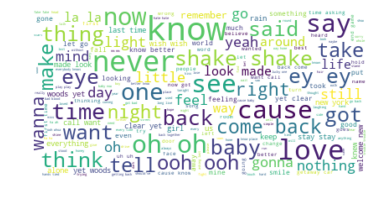

In [97]:
# Create and generate a word cloud image:

wordcloud = WordCloud(
                          background_color='white',
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(raw_text[0]))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
 vectorizer2 = TfidfVectorizer()